### Importações

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys

from sklearn.neighbors import LocalOutlierFactor

In [59]:
%reload_ext autoreload
sys.path.append(os.path.abspath('..'))
from functions.clean_df import load_and_combine_csvs,clean_dataframe,add_confidential_flags
from functions.state_imput import apply_state_estimation
from functions.feature_engineering import feature_engineering
from functions.preprocessing import get_preprocessor
from functions.models import run_lof

### Criar o DF

In [ ]:
raw_path = '../raw_data/'
df_raw = load_and_combine_csvs(raw_path)

df_clean = clean_dataframe(df_raw)

df_clean = add_confidential_flags(df_clean)
df_clean = apply_state_estimation(df_clean)
df_clean = feature_engineering(df_clean)

<class 'pandas.core.frame.DataFrame'>
Index: 307307 entries, 0 to 392088
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   CÓDIGO ÓRGÃO SUPERIOR   307307 non-null  int64         
 1   NOME ÓRGÃO SUPERIOR     307307 non-null  object        
 2   CÓDIGO ÓRGÃO            307307 non-null  int64         
 3   NOME ÓRGÃO              307307 non-null  object        
 4   CÓDIGO UNIDADE GESTORA  307307 non-null  int64         
 5   NOME UNIDADE GESTORA    307307 non-null  object        
 6   ANO EXTRATO             307307 non-null  int64         
 7   MÊS EXTRATO             307307 non-null  int64         
 8   CPF PORTADOR            289417 non-null  object        
 9   NOME PORTADOR           307307 non-null  object        
 10  CNPJ OU CPF FAVORECIDO  307307 non-null  int64         
 11  NOME FAVORECIDO         307307 non-null  object        
 12  TRANSAÇÃO               307307 non-

### Feature Engeniering necessárias para o LOF

In [63]:
## Frequência das categorias
cols_categoria = ['NOME ÓRGÃO', 'ESTADO_ESTIMADO', 'NOME FAVORECIDO']

for col in cols_categoria:
    freq_map = df_clean[col].value_counts(normalize=True)
    df_clean[f'FREQ_{col}'] = df_clean[col].map(freq_map)

In [64]:
# Média por Órgão no MÊS
df_clean['MEDIA_VALOR_ORGAO_MES'] = df_clean.groupby(['NOME ÓRGÃO', 'ANO EXTRATO', 'MÊS EXTRATO'])['VALOR TRANSAÇÃO'].transform('mean')

# Razão do valor da transação pela média do órgão no período
df_clean['RATIO_MES'] = df_clean['VALOR TRANSAÇÃO'] / df_clean['MEDIA_VALOR_ORGAO_MES']

### Selecionando as features e processando os dados

In [39]:
features_modelo = [
    'LOG_VALOR',
    'RATIO_MES',
    'ANO EXTRATO',
    'MÊS EXTRATO',
    'FREQ_NOME ÓRGÃO',
    'FREQ_ESTADO_ESTIMADO',
    'SIGILOSO',
    'FIM_SEMANA'
]

# Criando X
X = df_clean[features_modelo].copy().fillna(0)

In [33]:
preprocessor = get_preprocessor()
X_scaled = preprocessor.fit_transform(df_clean)

ruido = np.random.normal(0, 1e-5, X_scaled.shape)
X_final_lof = X_scaled + ruido

### Treinando o modelo

In [34]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01, n_jobs=-1)

# Fit / Predict
df_clean['LOF_LABEL'] = lof.fit_predict(X_final_lof)
df_clean['LOF_SCORE'] = lof.negative_outlier_factor_

### Visualização

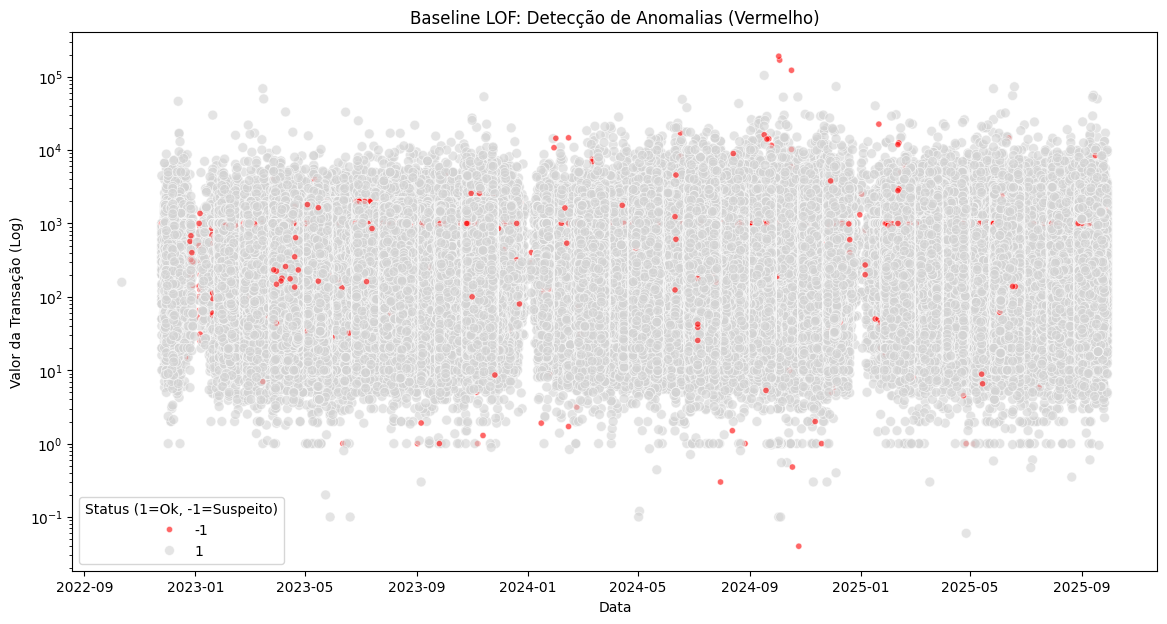

In [35]:
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=df_clean,
    x='DATA TRANSAÇÃO',
    y='VALOR TRANSAÇÃO',
    hue='LOF_LABEL',
    palette={1: 'lightgrey', -1: 'red'},
    alpha=0.6,
    size='LOF_LABEL',
    sizes=(20, 50)
)
plt.yscale('log')
plt.title('Baseline LOF: Detecção de Anomalias (Vermelho)')
plt.ylabel('Valor da Transação (Log)')
plt.xlabel('Data')
plt.legend(title='Status (1=Ok, -1=Suspeito)')
plt.show()

### Top suspeitos

In [38]:
cols_view = ['NOME ÓRGÃO', 'NOME FAVORECIDO', 'VALOR TRANSAÇÃO', 'DATA TRANSAÇÃO', 'ESTADO_ESTIMADO', 'LOF_SCORE']
top_anomalias = df_clean[df_clean['LOF_LABEL'] == -1].sort_values('LOF_SCORE', ascending=True).head(10)
top_anomalias.head(100)[cols_view]

,NOME ÓRGÃO,NOME FAVORECIDO,VALOR TRANSAÇÃO,DATA TRANSAÇÃO,ESTADO_ESTIMADO,LOF_SCORE
114890,Ministério do Meio Ambiente e Mudança do Clima...,NAO SE APLICA,1000.0,2023-01-05,UNIÃO,-37946.551353
299635,"VALEC Engenharia, Construções e Ferrovias S.A.",NAO SE APLICA,600.0,2024-12-20,UNIÃO,-15173.680391
349285,Presidência da República,NAO SE APLICA,1000.0,2023-12-20,PR,-15145.281892
114891,Ministério do Meio Ambiente e Mudança do Clima...,NAO SE APLICA,500.0,2023-01-05,UNIÃO,-13994.471389
299636,"VALEC Engenharia, Construções e Ferrovias S.A.",NAO SE APLICA,400.0,2024-12-20,UNIÃO,-11536.230824
297278,Instituto Chico Mendes de Conservação da Biodi...,NAO SE APLICA,60.0,2024-12-02,SE,-11013.155662
14868,"Instituto Federal de Educação, Ciência e Tecno...",NAO SE APLICA,1000.0,2022-11-29,ES,-7383.384060
14866,"Instituto Federal de Educação, Ciência e Tecno...",NAO SE APLICA,1000.0,2022-11-30,ES,-7383.159623
368647,Ministério da Defesa - Unidades com vínculo di...,NAO SE APLICA,1000.0,2023-08-21,UNIÃO,-7305.025917
368623,Ministério da Defesa - Unidades com vínculo di...,NAO SE APLICA,1000.0,2023-08-09,UNIÃO,-7304.961956


### Teste da função

In [65]:
df_final = run_lof(df_clean)

In [66]:
df_final.head()

,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CPF PORTADOR,NOME PORTADOR,...,ID_PORTADOR,FIM_SEMANA,LOG_VALOR,FREQ_NOME ÓRGÃO,FREQ_ESTADO_ESTIMADO,FREQ_NOME FAVORECIDO,MEDIA_VALOR_ORGAO_MES,RATIO_MES,LOF_LABEL,LOF_SCORE
0,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2025,6,***.945.361-**,CLAUDELI CONCEICAO DOS SANTOS,...,***.945.361-**CLAUDELI CONCEICAO DOS SANTOS,0,6.523562,0.006521,0.216305,0.098263,272.828333,2.492410,1,-1.047170
1,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2025,6,***.945.361-**,CLAUDELI CONCEICAO DOS SANTOS,...,***.945.361-**CLAUDELI CONCEICAO DOS SANTOS,0,6.478510,0.006521,0.216305,0.098263,272.828333,2.382451,1,-1.015627
2,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2025,6,***.945.361-**,CLAUDELI CONCEICAO DOS SANTOS,...,***.945.361-**CLAUDELI CONCEICAO DOS SANTOS,0,6.608001,0.006521,0.216305,0.098263,272.828333,2.712328,1,-1.021602
3,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2025,6,***.562.861-**,ANTONIO CARLOS MELO DOS SANTOS,...,***.562.861-**ANTONIO CARLOS MELO DOS SANTOS,0,6.111467,0.006521,0.216305,0.098263,272.828333,1.649389,1,-1.087932
4,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2025,6,***.562.861-**,ANTONIO CARLOS MELO DOS SANTOS,...,***.562.861-**ANTONIO CARLOS MELO DOS SANTOS,0,4.189655,0.006521,0.216305,0.000306,272.828333,0.238245,1,-1.096172
